In [80]:
import cv2
import numpy as np
import os
from google.colab import drive
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Section 2

First we load neutral images and show the first one as an example

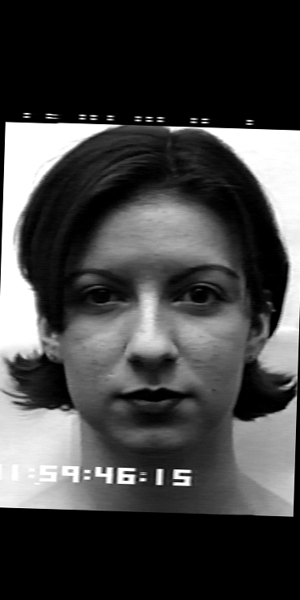

In [81]:
os.chdir('/content/drive/My Drive/Colab Notebooks/VisionLab/Cohn-Kanade/images/neutral')
images = []
for f in os.listdir():
  img = cv2.imread(f)
  images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
cv2_imshow(images[0])

The data was subsequently divided into training and validation sets. The first 138 samples, derived from 70 distinct subjects, were allocated to the training set, with the remaining samples assigned to the validation set.

In [82]:
x = np.array(images).reshape(190,-1)
x_test = x[:-26*2]
x_val = x[-26*2:]

Utilizing the technique described in the instructions, the first 10 eigenvectors are calculated and selected

In [98]:
m = np.mean(x_test, 0)
A = (x_test - m).T

R = A.T @ A
lam, v = np.linalg.eig(R)

order = np.argsort(lam)[::-1]
lam_10 = lam[order][:10]
v_10 = v[:, order][:, :10]

u_10 = A @ v_10
u_10 = u_10 / np.linalg.norm(u_10, axis=0)

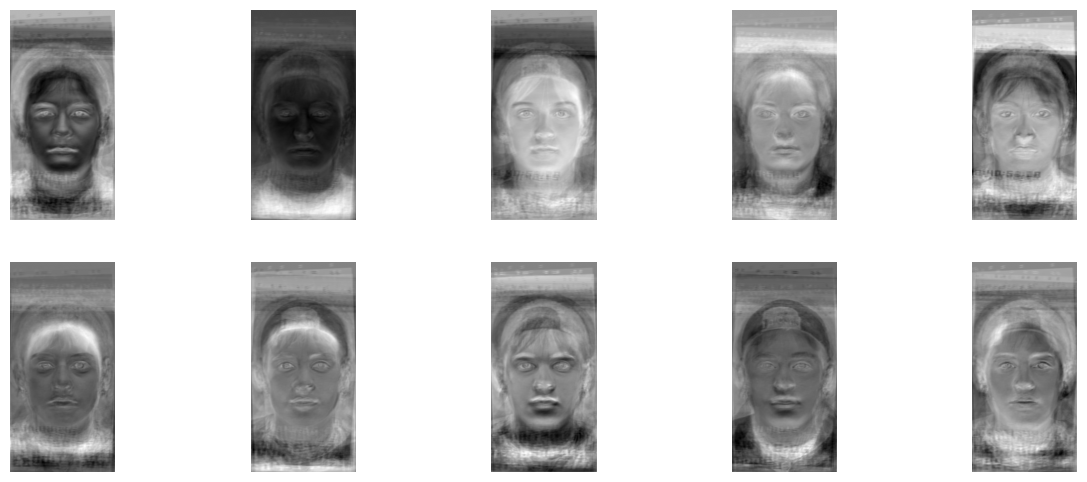

In [99]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(u_10.T[i].reshape(600,-1), cmap='gray')
    axes[i].axis(False)

These eigenvectors are subsequently utilized as a low-dimensional basis to reconstruct images. Consequently, the reconstructed images effectively represent the original data using only 10 dimensions.

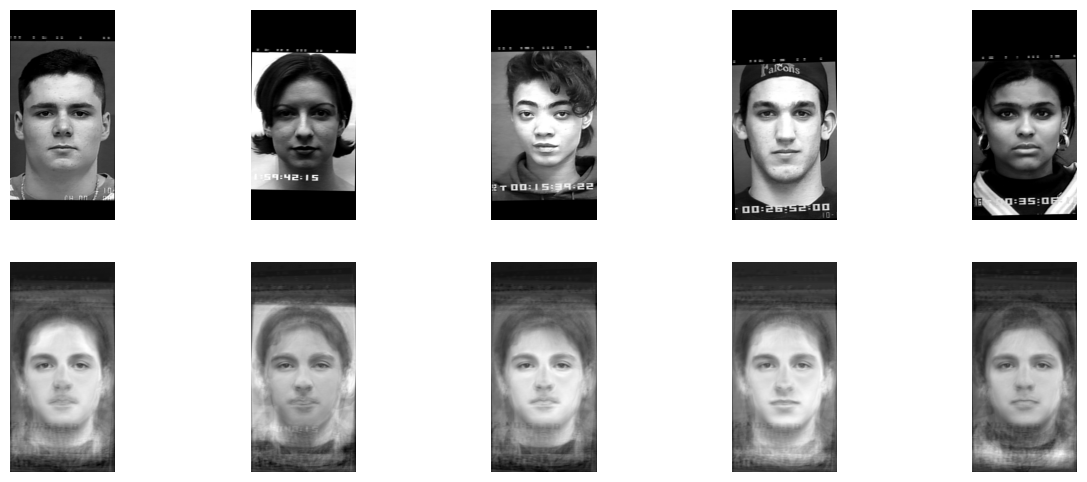

In [100]:
indexes = np.random.randint(x_test.shape[0], size=5)
x_compressed = u_10.T @ x_test[indexes].T
x_reconstruct = (u_10 @ x_compressed).T + m

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(5):
    axes[i].imshow(x_test[indexes[i]].reshape(600,-1), cmap='gray')
    axes[i].axis(False)

    axes[i+5].imshow(x_reconstruct[i].reshape(600,-1), cmap='gray')
    axes[i+5].axis(False)


The number of principal components was then increased to 20, and the reconstruction process was repeated.

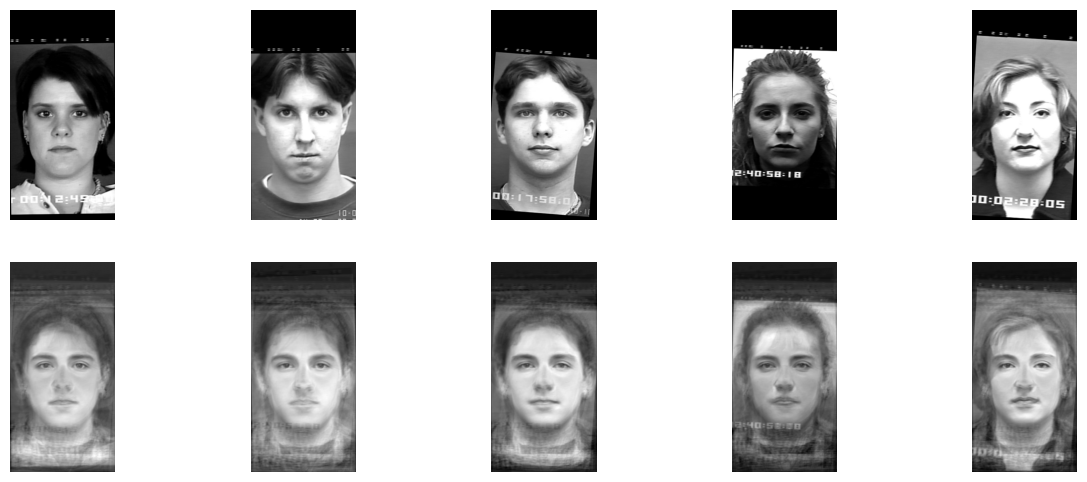

In [101]:
lam_20 = lam[order][:20]
v_20 = v[:, order][:, :20]

u_20 = A @ v_20
u_20 = u_20 / np.linalg.norm(u_20, axis=0)
u_20 = u_20.T

indexes = np.random.randint(x_test.shape[0], size=5)
x_compressed = u_20 @ x_test[indexes].T
x_reconstruct = (u_20.T @ x_compressed).T + m

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(5):
    axes[i].imshow(x_test[indexes[i]].reshape(600,-1), cmap='gray')
    axes[i].axis(False)

    axes[i+5].imshow(x_reconstruct[i].reshape(600,-1), cmap='gray')
    axes[i+5].axis(False)


As observed, the reconstruction quality has improved. There is a clearer distinction between images of different individuals, and the low-rank reconstructed images bear a closer resemblance to the originals.

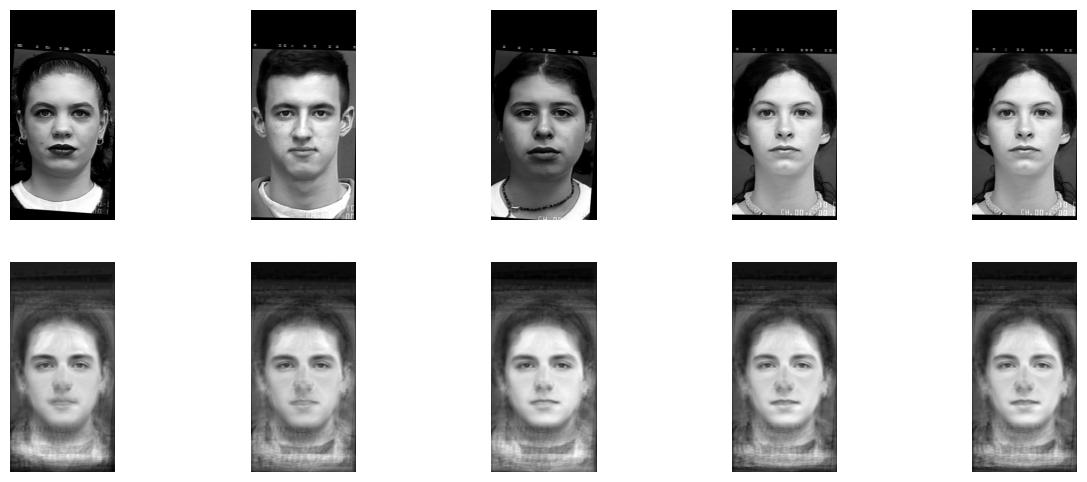

In [87]:
indexes = np.random.randint(x_val.shape[0], size=5)
x_compressed = u_20 @ x_val[indexes].T
x_reconstruct = (u_20.T @ x_compressed).T + m

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(5):
    axes[i].imshow(x_val[indexes[i]].reshape(600,-1), cmap='gray')
    axes[i].axis(False)

    axes[i+5].imshow(x_reconstruct[i].reshape(600,-1), cmap='gray')
    axes[i+5].axis(False)

In contrast, the reconstructions of the test do not resemble the original images. This discrepancy arises because the principal components were calculated based on the training set feature space. Furthermore, due to the small size of the training set, the selected components may not adequately generalize, making them less appropriate for efficiently representing the variance present in the unseen validation data.

## Section 3

An ellipsoidal mask was applied to isolate the face of individuals

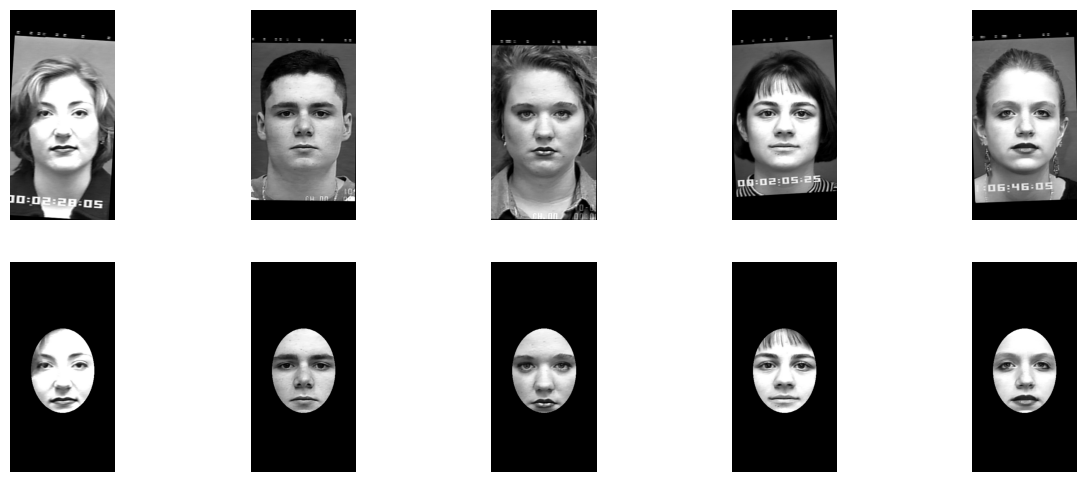

In [88]:
image_width = 300
image_height = 600

center_x = 150
center_y = 310

radius_x = 90
radius_y = 120

mask = np.zeros((image_height, image_width))

cv2.ellipse(
    img=mask,
    center=(center_x, center_y),
    axes=(radius_x, radius_y),
    angle=0,
    startAngle=0,
    endAngle=360,
    color=255,
    thickness=-1
)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

indexes = np.random.randint(x_test.shape[0], size=5)

for i in range(5):
    axes[i].imshow(x_test[indexes[i]].reshape(600,-1), cmap='gray')
    axes[i].axis(False)

    x_s = x_test[indexes[i]].copy()
    x_s[mask.flatten()==0] = 0
    axes[i+5].imshow(x_s.reshape(600,-1), cmap='gray')
    axes[i+5].axis(False)

mages corresponding to different emotional classes were loaded, and the top 10 principal components were calculated separately for each class.

In [90]:
def load_images(path):
    os.chdir(path)
    images = []
    for f in os.listdir():
        img = cv2.imread(f)
        images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    return np.array(images).reshape(len(images), -1)

base_dir = '/content/drive/My Drive/Colab Notebooks/VisionLab/Cohn-Kanade/images/'

x_n = load_images(base_dir + 'neutral')
x_h = load_images(base_dir + 'happy')
x_s = load_images(base_dir + 'surprise')
x_d = load_images(base_dir + 'disgust')

In [94]:
def eigs(x, k):
    global mask
    x[:, mask == 0] = 0
    m = np.mean(x, 0)
    A = (x-m).T

    R = A.T @ A
    lam, v = np.linalg.eigh(R)

    order = np.argsort(lam)[::-1]
    lam = lam[order][:k]
    v = v[:, order][:, :k]

    u = A @ v
    u = u / np.linalg.norm(u, axis=0)

    return lam, u

mask = mask.flatten()
l_n, u_n = eigs(x_n, 10)
l_h, u_h = eigs(x_h, 10)
l_d, u_d = eigs(x_d, 10)
l_s, u_s = eigs(x_s, 10)

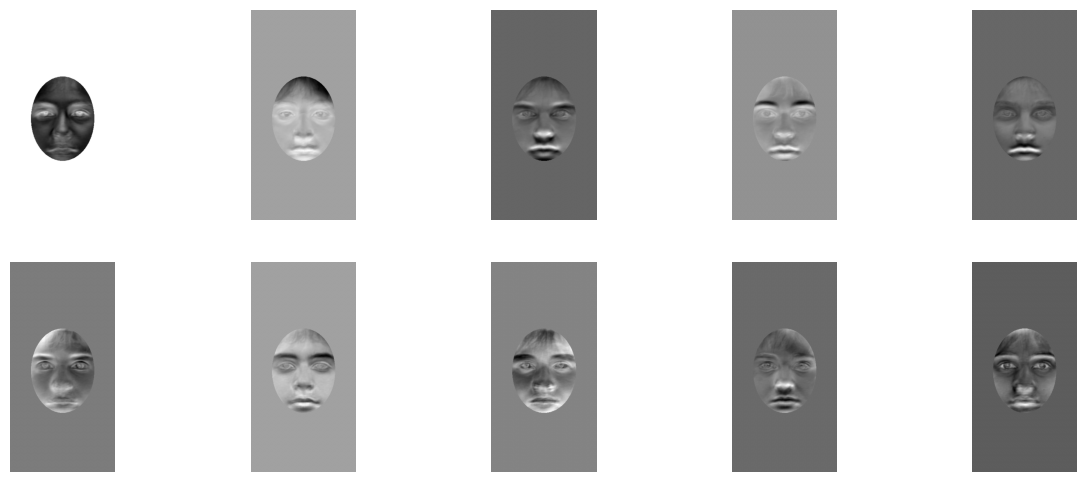

In [95]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(u_n.T[i].reshape(600,-1), cmap='gray')
    axes[i].axis(False)

Finally, 10 randomly selected neutral images were reconstructed by projecting them onto the subspaces defined by the Eigen-components of the other emotional classes.
This process resulted in a shift in expression on the reconstructed faces while preserving the core individual facial features.
Components of the face that do not play a significant role in expressing the target emotion are generally reconstructed with higher fidelity.

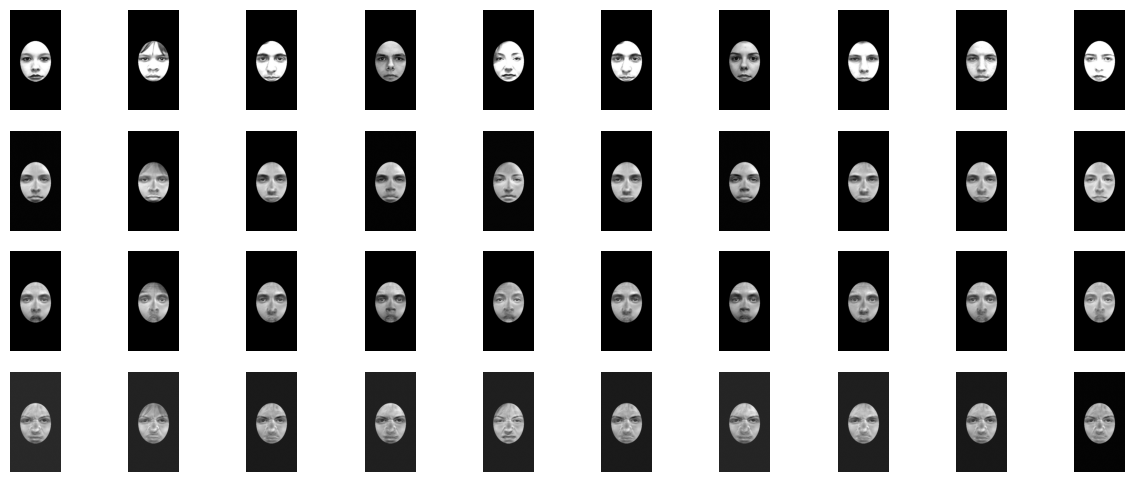

In [96]:
indexes = np.random.randint(x_test.shape[0], size=10)

fig, axes = plt.subplots(4, 10, figsize=(15, 6))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(x_n[indexes[i]].reshape(600,-1), cmap='gray')
    axes[i].axis(False)

    x_compressed = u_n.T @ x_n[indexes[i]].T
    x_reconstruct = (u_n @ x_compressed).T

    axes[i+10].imshow(x_reconstruct.reshape(600,-1), cmap='gray')
    axes[i+10].axis(False)

    x_compressed = u_s.T @ x_n[indexes[i]].T
    x_reconstruct = (u_s @ x_compressed).T

    axes[i+20].imshow(x_reconstruct.reshape(600,-1), cmap='gray')
    axes[i+20].axis(False)

    x_compressed = u_d.T @ x_n[indexes[i]].T
    x_reconstruct = (u_d @ x_compressed).T

    axes[i+30].imshow(x_reconstruct.reshape(600,-1), cmap='gray')
    axes[i+30].axis(False)